In [190]:
import copy
import importlib
import os
import re

import anndata
import numpy as np
# import starfysh
import pandas as pd
import scanpy as sc

import scvi
import seaborn as sns
from anndata import AnnData
# import starfysh
from matplotlib import pyplot as plt
from py_pcha import PCHA
from scipy.sparse import issparse
from scipy.spatial.distance import cdist
from scipy.stats import zscore
from sklearn.cluster import KMeans
# !pip install starfysh
# !pip install pandas
# !pip install scanpy
# !pip install histomicstk
# !pip install --upgrade pip setuptools wheel
# !pip install pyvips --use-pep517
# !pip install histomicstk --find-links https://girder.github.io/large_image_wheels
from sklearn.decomposition import PCA
from sympy.physics.units import current
from tqdm import tqdm

import bar_nick_utils

importlib.reload(bar_nick_utils)

from bar_nick_utils import preprocess_rna, preprocess_protein, plot_archetypes, \
    get_cell_representations_as_archetypes_cvxpy, reorder_rows_to_maximize_diagonal, evaluate_distance_metrics, \
    plot_archetypes_matching, compare_matchings, find_best_pair_by_row_matching, add_spatial_data_to_prot, \
    clean_uns_for_h5ad, get_latest_file
plot_flag = False
# computationally figure out which ones are best
np.random.seed(8)
! which python

/Users/nicholasdjedjos/miniconda3/envs/archetypegen/bin/python


### reading in data

In [191]:
# adata = sc.read("spleen_lymph_cite_seq.h5ad")
adata = scvi.data.spleen_lymph_cite_seq(save_path='data')
# adata for protein, rna take relevant info for each <for each sample>


INFO     File data/sln_111.h5ad already downloaded                                                                 
INFO     File data/sln_208.h5ad already downloaded                                                                 


/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [192]:
adata.obs['batch']

index
AAACCCAAGGGTAATT-1    SLN111-D1
AAACCCAAGGTAAACT-1    SLN111-D1
AAACCCACACTAGGTT-1    SLN111-D1
AAACCCACAGATACCT-1    SLN111-D1
AAACCCACAGGAATAT-1    SLN111-D1
                        ...    
TTTGTTGGTGGGCTCT-2    SLN208-D2
TTTGTTGTCAAATAGG-2    SLN208-D2
TTTGTTGTCACGAGGA-2    SLN208-D2
TTTGTTGTCTCGACCT-2    SLN208-D2
TTTGTTGTCTTGGTCC-2    SLN208-D2
Name: batch, Length: 30474, dtype: category
Categories (4, object): ['SLN111-D1', 'SLN111-D2', 'SLN208-D1', 'SLN208-D2']

In [193]:
adata_1 = adata[adata.obs['batch'] == f'SLN111-D1']
adata_2 = adata[adata.obs['batch'] == f'SLN111-D2']
fraction = 1
sc.pp.subsample(adata, fraction=fraction)
adata_1 = adata_1[adata_1.obs['cell_types'].argsort(), :]  # sort by cell types for easier visualization
adata_2 = adata_2[adata_2.obs['cell_types'].argsort(), :]  # sort by cell types for easier visualization

# initial_adata_rna = adata[adata.obs['batch'] == f'SLN111-D1']
# initial_adata_protein = adata[adata.obs['batch'] == f'SLN208-D1'] 
# get rna from one patient, protein from the other then run the whole archetype analysis
# cell type protein, cell type rna, see which one's 

/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [194]:
adata_1

View of AnnData object with n_obs × n_vars = 8736 × 13553
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'
    obsm: 'isotypes_htos', 'protein_expression'

In [195]:
# old code
adata = adata[adata.obs['batch'] == f'SLN111-D1']
fraction = 1
sc.pp.subsample(adata, fraction=fraction)
adata = adata[adata.obs['cell_types'].argsort(), :]  # sort by cell types for easier visualization

# initial_adata_rna = adata[adata.obs['batch'] == f'SLN111-D1']
# initial_adata_protein = adata[adata.obs['batch'] == f'SLN111-D2'] 
# # get rna from one patient, protein from the other then run the whole archetype analysis
# # cell type protein, cell type rna, see which one's 

In [196]:
cell_type_mapping = {
    "Activated CD4 T": "CD4 T",
    "B1 B": "B cells",
    "CD122+ CD8 T": "CD8 T",
    "CD4 T": "CD4 T",
    "CD8 T": "CD8 T",
    "Erythrocytes": "RBC",
    "GD T": "T cells",
    "ICOS-high Tregs": "CD4 T",
    "Ifit3-high B": "B cells",
    "Ifit3-high CD4 T": "CD4 T",
    "Ifit3-high CD8 T": "CD8 T",
    "Ly6-high mono": "Monocytes",
    "Ly6-low mono": "Monocytes",
    "MZ B": "B cells",
    "MZ/Marco-high macrophages": "Macrophages",
    "Mature B": "B cells",
    "Migratory DCs": "cDCs",
    "NK": "NK",
    "NKT": "T cells",
    "Neutrophils": "Neutrophils",
    "Plasma B": "B cells",
    "Red-pulp macrophages": "Macrophages",
    "Transitional B": "B cells",
    "Tregs": "Treg",
    "cDC1s": "cDCs",
    "cDC2s": "cDCs",
    "pDCs": "pDCs",
}
# Map the specific cell types to major cell types and add as a new column in obs
adata.obs['major_cell_types'] = pd.Categorical(adata.obs['cell_types'].map(cell_type_mapping))

adata_1.obs['major_cell_types'] = pd.Categorical(adata_1.obs['cell_types'].map(cell_type_mapping))
adata_2.obs['major_cell_types'] = pd.Categorical(adata_2.obs['cell_types'].map(cell_type_mapping))

assert set(cell_type_mapping.keys()) == set(adata.obs['cell_types'])

/var/folders/gt/1c8d4lks1vgbghz7rr9vnqzm0000gn/T/ipykernel_76677/2018100268.py:31: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['major_cell_types'] = pd.Categorical(adata.obs['cell_types'].map(cell_type_mapping))
/var/folders/gt/1c8d4lks1vgbghz7rr9vnqzm0000gn/T/ipykernel_76677/2018100268.py:33: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_1.obs['major_cell_types'] = pd.Categorical(adata_1.obs['cell_types'].map(cell_type_mapping))
/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `

In [184]:
adata_1

AnnData object with n_obs × n_vars = 8736 × 13553
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'major_cell_types'
    obsm: 'isotypes_htos', 'protein_expression'

In [185]:
print(adata_1.obs['major_cell_types'].value_counts())
print(adata_2.obs['major_cell_types'].value_counts())

major_cell_types
B cells        4458
CD4 T          1857
CD8 T          1427
T cells         228
cDCs            190
Treg            135
Monocytes       109
NK              104
Neutrophils      95
Macrophages      82
pDCs             27
RBC              24
Name: count, dtype: int64
major_cell_types
B cells        3527
CD4 T          1449
CD8 T          1079
T cells         190
cDCs            145
Treg            125
Macrophages      87
Monocytes        73
Neutrophils      70
NK               67
pDCs             37
RBC              19
Name: count, dtype: int64


In [186]:
adata.obs['major_cell_types'].value_counts()

major_cell_types
B cells        4459
CD4 T          1892
CD8 T          1432
T cells         219
cDCs            181
Treg            151
Monocytes        99
Macrophages      95
NK               82
Neutrophils      53
pDCs             41
RBC              32
Name: count, dtype: int64

### preprocessing RNA protein

In [197]:
# Filter cells and genes (same sample)
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=20)
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3')
adata = adata[:, adata.var['highly_variable']]
print(f"Selected {adata.shape[1]} highly variable genes.")
# PCA after selecting highly variable genes
sc.pp.pca(adata)
print(
    f"Variance ratio after highly variable gene selection PCA (10 PCs): {adata.uns['pca']['variance_ratio'][:10].sum():.4f}")

Selected 2000 highly variable genes.
Variance ratio after highly variable gene selection PCA (10 PCs): 0.9377


/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [169]:
# Filter cells and genes (different sample)
sc.pp.filter_cells(adata_1, min_genes=100)
sc.pp.filter_genes(adata_1, min_cells=20)
# Identify highly variable genes
sc.pp.highly_variable_genes(adata_1, n_top_genes=2000, flavor='seurat_v3')
adata_1 = adata_1[:, adata_1.var['highly_variable']]
print(f"Selected {adata_1.shape[1]} highly variable genes.")
# PCA after selecting highly variable genes
sc.pp.pca(adata_1)
print(
    f"Variance ratio after highly variable gene selection PCA (10 PCs): {adata_1.uns['pca']['variance_ratio'][:10].sum():.4f}")

/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Selected 2000 highly variable genes.
Variance ratio after highly variable gene selection PCA (10 PCs): 0.9685


/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [198]:

# initial adata code
adata.obs['cell_types'] = pd.Categorical(adata.obs['cell_types'])
adata.obs['major_cell_types'] = pd.Categorical( adata.obs['cell_types'].map(cell_type_mapping)) # why is this done again?

adata = adata[
    adata.obs.sort_values(by=['major_cell_types', 'cell_types']).index
]
# remove protein_expression from adatan/
adata_rna = adata.copy()
sc.pp.pca(adata_rna)
print(f'variance explained by first 10 PCs {adata_rna.uns["pca"]["variance_ratio"][:10].sum()}')
adata_rna = preprocess_rna(adata_rna) # we do some repeated preprocessing but I think it's okay
sc.pp.pca(adata_rna)

print(f'variance explained by first 10 PCs {adata_rna.uns["pca"]["variance_ratio"][:10].sum()}')
adata_rna.obsm.pop('protein_expression')
# assert len(set(adata.obs['batch']))!=1
adata_prot = AnnData(adata.obsm['protein_expression'])
# add all obs and var to adata_prot
adata_prot.obs = adata_rna.obs
# remove n_genes and percent_mito from adata_prot
adata_prot.obs = adata_prot.obs.drop(columns=['n_genes', 'percent_mito'])
adata_prot = preprocess_protein(adata_prot)
adata_prot.obsm.pop('X_pca')
adata_prot.varm.pop('PCs')

# take only the first batch from adata_prot and adata_rna
# first_batch = adata_prot.obs['batch'][0]
# take the largest batch
# larget_batch = adata_prot.obs['batch'].value_counts().idxmax()
original_protein_num = adata_prot.X.shape[1]

del adata

variance explained by first 10 PCs 0.9376918077468872
Variance ratio after log transformation PCA (10 PCs): 0.4095
Variance ratio after normalization PCA (10 PCs): 0.3723
variance explained by first 10 PCs 0.3723090887069702
Variance ratio after PCA (10 PCs): 0.9311

Variance ratio after normalization PCA (10 PCs): 0.9303

Variance ratio after log transformation PCA (10 PCs): 0.6771


In [200]:
# initial adata code (different samples) (takes a little while longer for some reason)
adata_1.obs['cell_types'] = pd.Categorical(adata_1.obs['cell_types'])
adata_1.obs['major_cell_types'] = pd.Categorical( adata_1.obs['cell_types'].map(cell_type_mapping)) # why is this done again?

# ran into this: InvalidIndexError: Reindexing only valid with uniquely valued Index objects
# adata_1 = adata_1[
#     adata_1.obs.sort_values(by=['major_cell_types', 'cell_types']).index
# ]
# so only kept reoccurence of first cell here
adata_1 = adata_1[
    ~adata_1.obs.index.duplicated(keep='first') 
]
adata_1 = adata_1[
    adata_1.obs.sort_values(by=['major_cell_types', 'cell_types']).index
]

adata_1_rna = adata_1.copy()
sc.pp.pca(adata_1_rna)
print(f'variance explained by first 10 PCs {adata_1_rna.uns["pca"]["variance_ratio"][:10].sum()}')
adata_1_rna = preprocess_rna(adata_1_rna)
sc.pp.pca(adata_1_rna)

adata_1_rna.obsm.pop('protein_expression')
# assert len(set(adata.obs['batch']))!=1

adata_2_prot = AnnData(adata_2.obsm['protein_expression'])
# # add all obs and var to adata_prot
# adata_prot.obs = adata_rna.obs (this is a potential problem as rna and protein obs don't match currently)
adata_2_prot.obs = adata_2.obs 
# remove n_genes and percent_mito from adata_prot
adata_2_prot.obs = adata_2_prot.obs.drop(columns=['n_genes', 'percent_mito'])
adata_2_prot = preprocess_protein(adata_2_prot)
adata_2_prot.obsm.pop('X_pca')
adata_2_prot.varm.pop('PCs')
 
# del adata

variance explained by first 10 PCs 0.9322007933106424
Variance ratio after log transformation PCA (10 PCs): 0.2523
Variance ratio after normalization PCA (10 PCs): 0.1654


/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Variance ratio after PCA (10 PCs): 0.9342

Variance ratio after normalization PCA (10 PCs): 0.9287

Variance ratio after log transformation PCA (10 PCs): 0.6696


array([[-0.0597916 , -0.00706302, -0.04411351, ...,  0.04206474,
         0.00208723, -0.00303072],
       [ 0.03792439,  0.1189851 , -0.11254911, ..., -0.01906934,
        -0.1136544 , -0.01988921],
       [-0.00991985, -0.01965413, -0.11892197, ...,  0.08121344,
         0.02041543,  0.07990132],
       ...,
       [-0.00263174, -0.01221807, -0.10152618, ...,  0.0456593 ,
         0.42671213, -0.01512007],
       [-0.00427242, -0.02281289, -0.11117478, ...,  0.13255005,
         0.04105202, -0.05744004],
       [ 0.01049267,  0.10017944,  0.00649441, ..., -0.07555816,
        -0.08238228,  0.00769935]], dtype=float32)

# Synthetic spatial data generation

In [201]:
# generate major cell types
cell_type_mapping = {
    "Activated CD4 T": "CD4 T",
    "B1 B": "B cells",
    "CD122+ CD8 T": "CD8 T",
    "CD4 T": "CD4 T",
    "CD8 T": "CD8 T",
    "Erythrocytes": "RBC",
    "GD T": "T cells",
    "ICOS-high Tregs": "CD4 T",
    "Ifit3-high B": "B cells",
    "Ifit3-high CD4 T": "CD4 T",
    "Ifit3-high CD8 T": "CD8 T",
    "Ly6-high mono": "Monocytes",
    "Ly6-low mono": "Monocytes",
    "MZ B": "B cells",
    "MZ/Marco-high macrophages": "Macrophages",
    "Mature B": "B cells",
    "Migratory DCs": "cDCs",
    "NK": "NK",
    "NKT": "T cells",
    "Neutrophils": "Neutrophils",
    "Plasma B": "B cells",
    "Red-pulp macrophages": "Macrophages",
    "Transitional B": "B cells",
    "Tregs": "Treg",
    "cDC1s": "cDCs",
    "cDC2s": "cDCs",
    "pDCs": "pDCs",
}
major_to_minor_dict ={}
# from major to minor dict
for k,v in cell_type_mapping.items():
    if v not in major_to_minor_dict:
        major_to_minor_dict[v] = [k]
    else:
        major_to_minor_dict[v].append(k)

In [202]:
# and placing the cells in the regions
# (initial adata method)
adata_prot,horizontal_splits,vertical_splits = add_spatial_data_to_prot(adata_prot, major_to_minor_dict)
adata_prot.obsm['spatial_location'] = pd.DataFrame([adata_prot.obs['X'],adata_prot.obs['Y']]).T
if plot_flag:
    sc.pl.scatter(adata_prot[adata_prot.obs['major_cell_types']=='B cells'], x='X', y='Y', color='cell_types', title='B Cell subtypes locations')
    sc.pl.scatter(adata_prot[adata_prot.obs['major_cell_types']=='CD4 T'], x='X', y='Y', color='cell_types', title='T Cell subtypes locations')
    sc.pl.scatter(adata_prot[adata_prot.obs['major_cell_types']=='CD8 T'], x='X', y='Y', color='cell_types', title='T Cell subtypes locations')


/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/scanpy/plotting/_utils.py:488: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


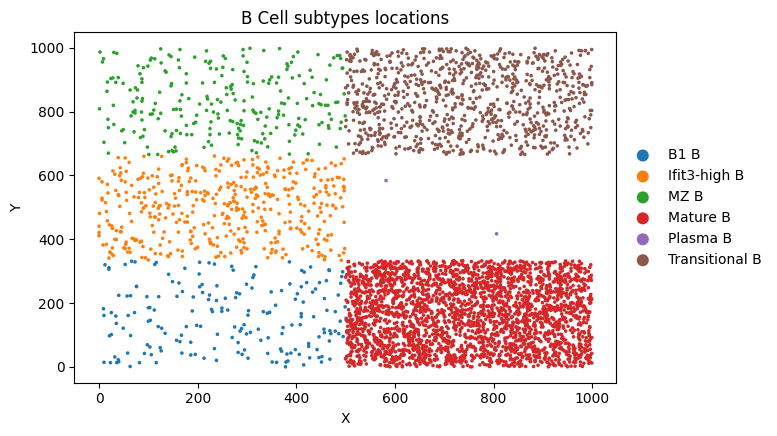

/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/scanpy/plotting/_utils.py:488: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


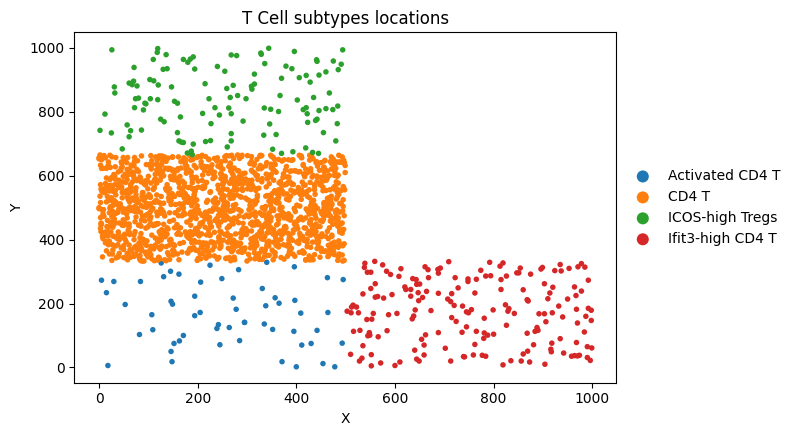

/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/scanpy/plotting/_utils.py:488: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


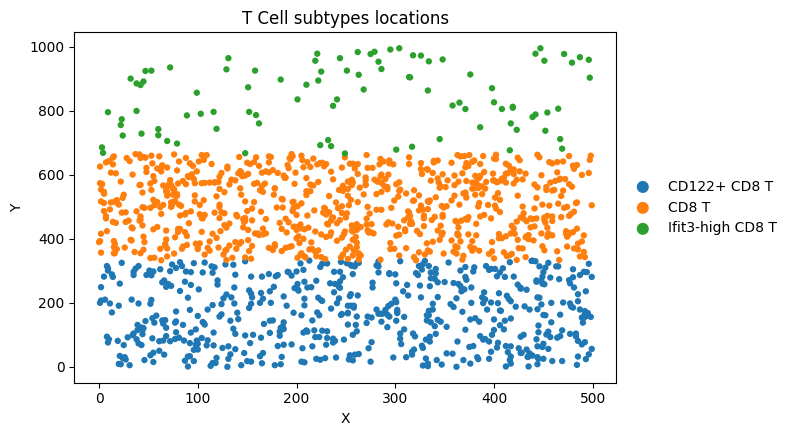

In [208]:
# and placing the cells in the regions
# (different sample)
# plot_flag=True
# had duplicate indices in the protein data here; this appends a 0,1,2,3 etc to make them unique
# important to do the obsm spatial location operation
if not adata_2_prot.obs.index.is_unique:
    adata_2_prot.obs.index = pd.Index(
        [f"{idx}_{i}" for i, idx in enumerate(adata_2_prot.obs.index)]
    )
adata_2_prot,horizontal_splits,vertical_splits = add_spatial_data_to_prot(adata_2_prot, major_to_minor_dict)
adata_2_prot.obsm['spatial_location'] = pd.DataFrame([adata_2_prot.obs['X'],adata_2_prot.obs['Y']]).T
if plot_flag:
    sc.pl.scatter(adata_prot[adata_prot.obs['major_cell_types']=='B cells'], x='X', y='Y', color='cell_types', title='B Cell subtypes locations')
    sc.pl.scatter(adata_prot[adata_prot.obs['major_cell_types']=='CD4 T'], x='X', y='Y', color='cell_types', title='T Cell subtypes locations')
    sc.pl.scatter(adata_prot[adata_prot.obs['major_cell_types']=='CD8 T'], x='X', y='Y', color='cell_types', title='T Cell subtypes locations')


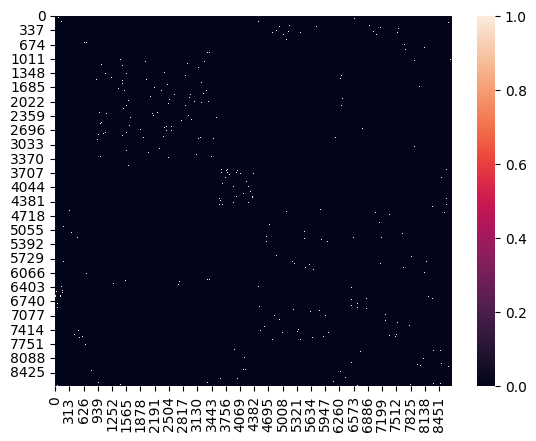

In [218]:
# (initial adata method)
sc.pp.neighbors(adata_prot,use_rep='spatial_location')

connectivities = adata_prot.obsp['connectivities']
connectivities[connectivities>0]=1
assert np.array_equal(np.array([0., 1.], dtype=np.float32), np.unique(np.array(connectivities.todense())))
if plot_flag:
    # sns.heatmap(connectivities.todense()[:1000,:1000])
    sns.heatmap(connectivities.todense()[:10000,:10000])

In [223]:
# (different sample)
plot_flag=False
sc.pp.neighbors(adata_2_prot,use_rep='spatial_location')

connectivities = adata_2_prot.obsp['connectivities']
connectivities[connectivities>0]=1
assert np.array_equal(np.array([0., 1.], dtype=np.float32), np.unique(np.array(connectivities.todense())))
if plot_flag:
    # sns.heatmap(connectivities.todense()[:1000,:1000])
    sns.heatmap(connectivities.todense()[:10000,:10000])

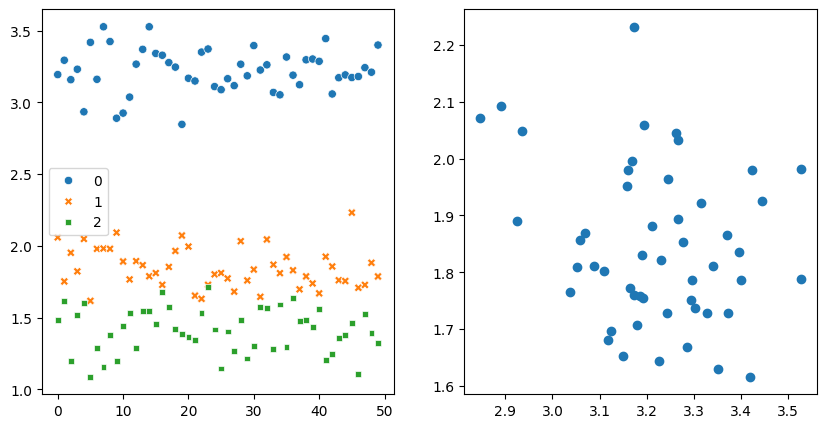

In [219]:
# (initial adata)
neighbor_sums = connectivities.dot(adata_prot.X) # get the sum of all neighbors
# neighbor_means = neighbor_sums/(0.00001+neighbor_sums.sum(1))[:,np.newaxis] # normalize
neighbor_means = np.asarray(neighbor_sums/connectivities.sum(1))
if plot_flag:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.scatterplot(neighbor_means[:50,:3])
    plt.subplot(1,2,2)
    plt.scatter(neighbor_means[:50,0],neighbor_means[:50,1])

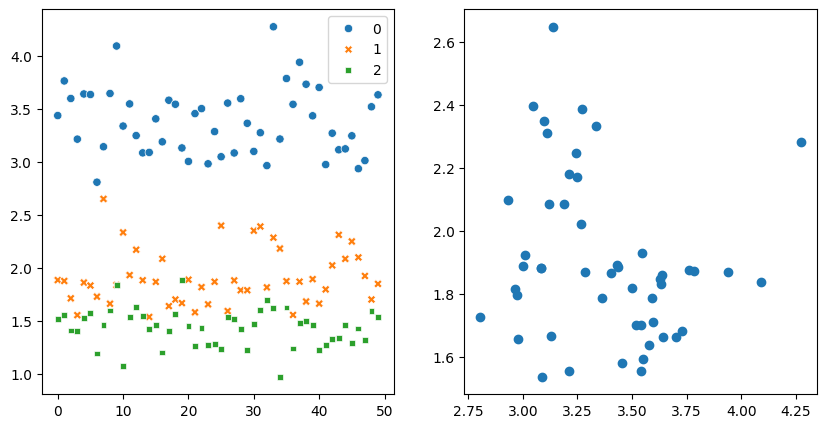

In [224]:
neighbor_sums = connectivities.dot(adata_2_prot.X) # get the sum of all neighbors
# neighbor_means = neighbor_sums/(0.00001+neighbor_sums.sum(1))[:,np.newaxis] # normalize
plot_flag=True
neighbor_means = np.asarray(neighbor_sums/connectivities.sum(1))
if plot_flag:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.scatterplot(neighbor_means[:50,:3])
    plt.subplot(1,2,2)
    plt.scatter(neighbor_means[:50,0],neighbor_means[:50,1])

In [220]:
# (initial adata)
# Standardize the data
normalized_data = zscore(neighbor_means, axis=0)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(normalized_data)

final_labels = np.array(kmeans.labels_)
if 'CN' in adata_prot.obs:
    adata_prot.obs.drop(columns=['CN'], inplace=True, errors='ignore')
    adata_rna.obs.drop(columns=['CN'], inplace=True, errors='ignore')
adata_prot.obs['CN'] = pd.Categorical(final_labels)
adata_rna.obs['CN'] = pd.Categorical(final_labels)
num_clusters = len(adata_prot.obs['CN'].unique())

palette = sns.color_palette("tab10", num_clusters)  # "tab10" is a good color map, you can choose others too
adata_prot.uns['spatial_clusters_colors'] = palette.as_hex()  # Save as hex color codes


In [228]:
# (different samples)
# since we have different samples, we need different final labels after the clustering
# Standardize the data
normalized_data = zscore(neighbor_means, axis=0)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(normalized_data)

final_labels = np.array(kmeans.labels_)
if 'CN' in adata_2_prot.obs:
    adata_2_prot.obs.drop(columns=['CN'], inplace=True, errors='ignore')
    # adata_1_rna.obs.drop(columns=['CN'], inplace=True, errors='ignore')
adata_2_prot.obs['CN'] = pd.Categorical(final_labels)
# adata_1_rna.obs['CN'] = pd.Categorical(final_labels)
num_clusters = len(adata_prot.obs['CN'].unique())

palette = sns.color_palette("tab10", num_clusters)  # "tab10" is a good color map, you can choose others too
adata_2_prot.uns['spatial_clusters_colors'] = palette.as_hex()  # Save as hex color codes


In [226]:
print(final_labels)

[0 4 1 ... 1 4 0]


In [14]:
# Convert X to a dense array if needed (only if memory allows)


# adata_prot_cn_concat =anndata.concat([adata_prot, neighbor_adata], join='outer', label='modality', keys=['RNA', 'Protein'])
# sc.pp.pca(adata_prot_cn_concat)
# sc.pp.neighbors(adata_prot_cn_concat)
# sc.tl.umap(adata_prot_cn_concat)
# sc.pl.umap(adata_prot_cn_concat, title='UMAP of CN embedding')



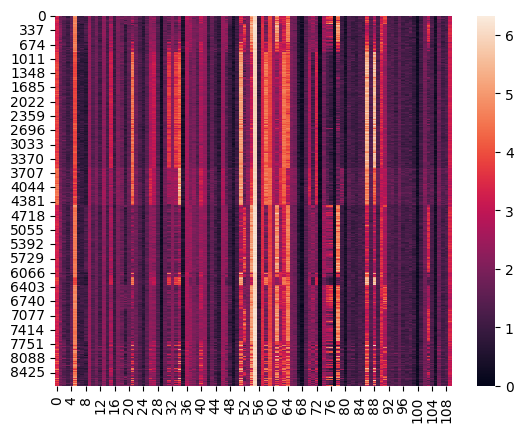

<Axes: >

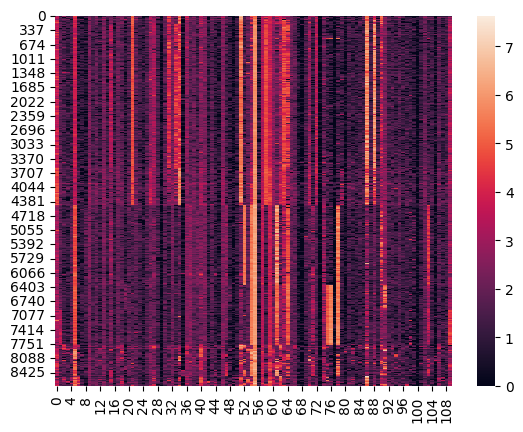

In [221]:
sns.heatmap(neighbor_means)
plt.show()
sns.heatmap(adata_prot.X)

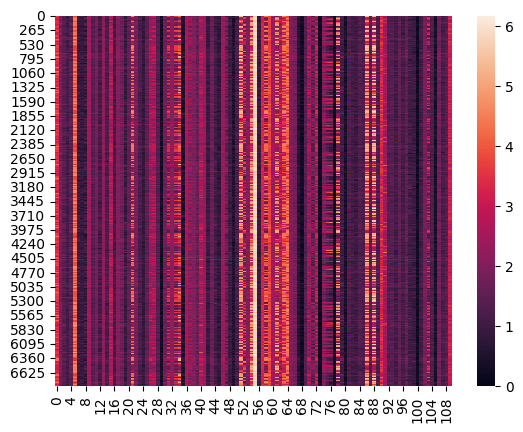

<Axes: >

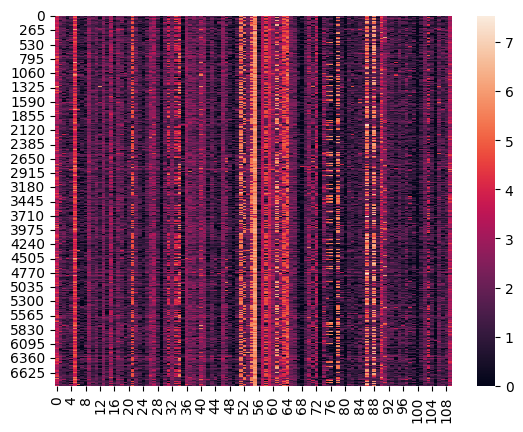

In [229]:
sns.heatmap(neighbor_means)
plt.show()
sns.heatmap(adata_2_prot.X)

In [16]:
# (initial adata technique)
if plot_flag:
    # merge the CN to the protein data
    fig, ax = plt.subplots()
    sc.pl.scatter(
        adata_prot,
        x='X', y='Y',
        color='CN',
        title='Cluster cells by their CN, can see the different CN in different regions, \nthanks to the different B cell types in each region',
        ax=ax,  # Use the ax created above
        show=False  # Prevent scanpy from showing the plot immediately
    )
    for x in horizontal_splits[1:-1]:  # Exclude the edges to avoid border doubling
        ax.axvline(x=x, color='black', linestyle='--')
    for y in vertical_splits[1:-1]:  # Exclude the edges to avoid border doubling
        ax.axhline(y=y, color='black', linestyle='--')
    plt.show()
    
    neighbor_adata = anndata.AnnData(neighbor_means)
    neighbor_adata.obs['CN'] = pd.Categorical(adata_rna.obs['CN'])
    sc.pp.pca(neighbor_adata)
    sc.pp.neighbors(neighbor_adata)
    sc.tl.umap(neighbor_adata)
    sc.pl.umap(neighbor_adata, color='CN', title='UMAP of CN embedding')

    # making sure the CN and the protein are distinct
    adata_prot_cn_concat =anndata.concat([adata_prot, neighbor_adata], join='outer', label='modality', keys=['Protein','CN'])
    X = adata_prot_cn_concat.X.toarray() if issparse(adata_prot_cn_concat.X) else adata_prot_cn_concat.X
    X = np.nan_to_num(X)
    adata_prot_cn_concat.X = X
    sc.pp.pca(adata_prot_cn_concat)
    sc.pp.neighbors(adata_prot_cn_concat)
    sc.tl.umap(adata_prot_cn_concat)
    sc.pl.umap(adata_prot_cn_concat,color=['CN','modality'],title=['UMAP of CN embedding','UMAP of CN embedding'])
    sc.pl.pca(adata_prot_cn_concat, color=['CN','modality'], title=['PCA of CN embedding','PCA of CN embedding'])


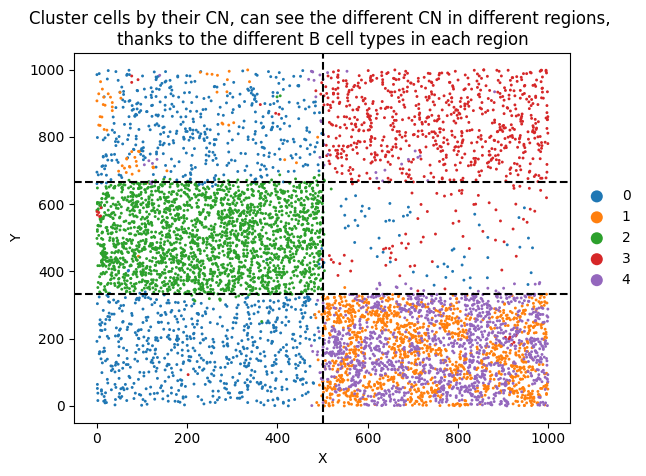

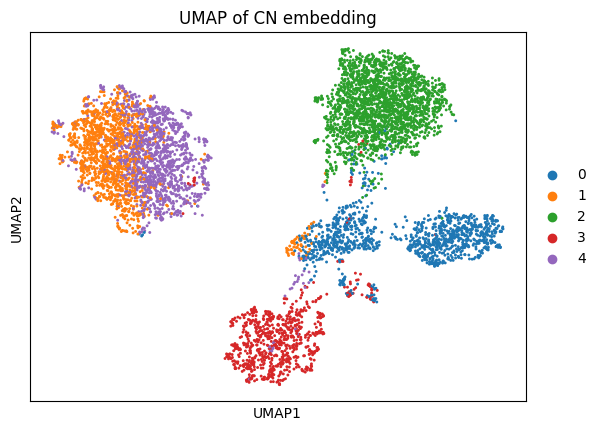

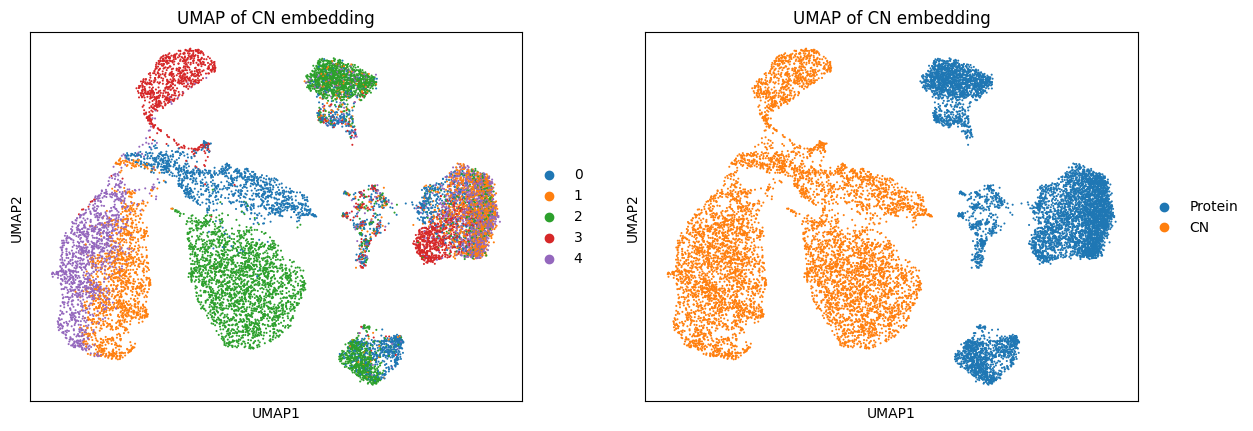

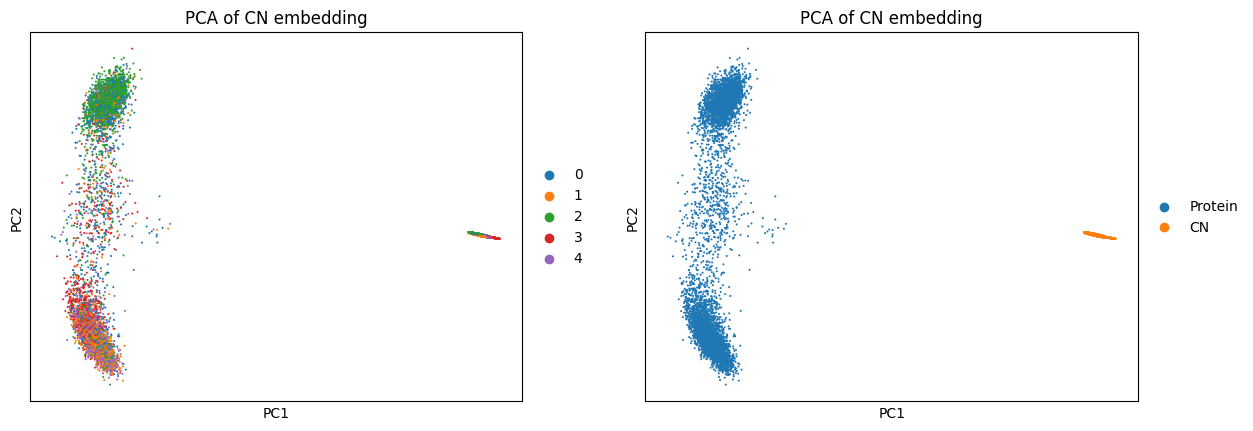

In [232]:
# (different adata technique)
if plot_flag:
    # merge the CN to the protein data
    fig, ax = plt.subplots()
    sc.pl.scatter(
        adata_2_prot,
        x='X', y='Y',
        color='CN',
        title='Cluster cells by their CN, can see the different CN in different regions, \nthanks to the different B cell types in each region',
        ax=ax,  # Use the ax created above
        show=False  # Prevent scanpy from showing the plot immediately
    )
    for x in horizontal_splits[1:-1]:  # Exclude the edges to avoid border doubling
        ax.axvline(x=x, color='black', linestyle='--')
    for y in vertical_splits[1:-1]:  # Exclude the edges to avoid border doubling
        ax.axhline(y=y, color='black', linestyle='--')
    plt.show()
    
    neighbor_adata = anndata.AnnData(neighbor_means)

    # rna no longer has the CN, using the protein
    neighbor_adata.obs['CN'] = pd.Categorical(adata_2_prot.obs['CN'])

    
    sc.pp.pca(neighbor_adata)
    sc.pp.neighbors(neighbor_adata)
    sc.tl.umap(neighbor_adata)
    sc.pl.umap(neighbor_adata, color='CN', title='UMAP of CN embedding')

    # making sure the CN and the protein are distinct
    adata_prot_cn_concat =anndata.concat([adata_2_prot, neighbor_adata], join='outer', label='modality', keys=['Protein','CN'])
    X = adata_prot_cn_concat.X.toarray() if issparse(adata_prot_cn_concat.X) else adata_prot_cn_concat.X
    X = np.nan_to_num(X)
    adata_prot_cn_concat.X = X
    sc.pp.pca(adata_prot_cn_concat)
    sc.pp.neighbors(adata_prot_cn_concat)
    sc.tl.umap(adata_prot_cn_concat)
    sc.pl.umap(adata_prot_cn_concat,color=['CN','modality'],title=['UMAP of CN embedding','UMAP of CN embedding'])
    sc.pl.pca(adata_prot_cn_concat, color=['CN','modality'], title=['PCA of CN embedding','PCA of CN embedding'])


In [17]:
adata_prot.X.shape[1] , neighbor_means.shape[1]

(110, 110)

In [18]:
# Assuming `adata_prot` is the original AnnData object
# And `neighbor_means` is the new matrix to be concatenated
# initial adata
new_feature_names = [f"CN_{i}" for i in adata_prot.var.index]
if adata_prot.X.shape[1] == neighbor_means.shape[1]:
    new_X = np.hstack([adata_prot.X, neighbor_means])
    additional_var = pd.DataFrame(index=new_feature_names)
    new_vars = pd.concat([adata_prot.var, additional_var])
else:
    new_X = adata_prot.X
    new_vars = adata_prot.var

adata_prot = anndata.AnnData(
    X=new_X,
    obs=adata_prot.obs.copy(),   # Keep the same observation metadata
    var= new_vars,   # Keep the same variable metadata
    uns=adata_prot.uns.copy(),   # Keep the same unstructured data
    obsm=adata_prot.obsm.copy(), # Keep the same observation matrices
    # varm=adata_prot.varm.copy(), # Keep the same variable matrices
    layers=adata_prot.layers.copy()  # Keep the same layers
)
adata_prot.var['feature_type'] = ['protein'] * original_protein_num + ['CN'] * neighbor_means.shape[1]
sc.pp.pca(adata_prot) # rerun PCA
print(f"New adata shape: {adata_prot.shape}")


New adata shape: (8736, 220)


In [234]:
# Assuming `adata_prot` is the original AnnData object
# And `neighbor_means` is the new matrix to be concatenated
# different adata
new_feature_names = [f"CN_{i}" for i in adata_2_prot.var.index]
if adata_2_prot.X.shape[1] == neighbor_means.shape[1]:
    new_X = np.hstack([adata_2_prot.X, neighbor_means])
    additional_var = pd.DataFrame(index=new_feature_names)
    new_vars = pd.concat([adata_prot.var, additional_var])
else:
    new_X = adata_2_prot.X
    new_vars = adata_2_prot.var

adata_2_prot = anndata.AnnData(
    X=new_X,
    obs=adata_2_prot.obs.copy(),   # Keep the same observation metadata
    var= new_vars,   # Keep the same variable metadata
    uns=adata_2_prot.uns.copy(),   # Keep the same unstructured data
    obsm=adata_2_prot.obsm.copy(), # Keep the same observation matrices
    # varm=adata_prot.varm.copy(), # Keep the same variable matrices
    layers=adata_2_prot.layers.copy()  # Keep the same layers
)
adata_2_prot.var['feature_type'] = ['protein'] * original_protein_num + ['CN'] * neighbor_means.shape[1]
sc.pp.pca(adata_2_prot) # rerun PCA
print(f"New adata shape: {adata_2_prot.shape}")


New adata shape: (6868, 220)


<Axes: >

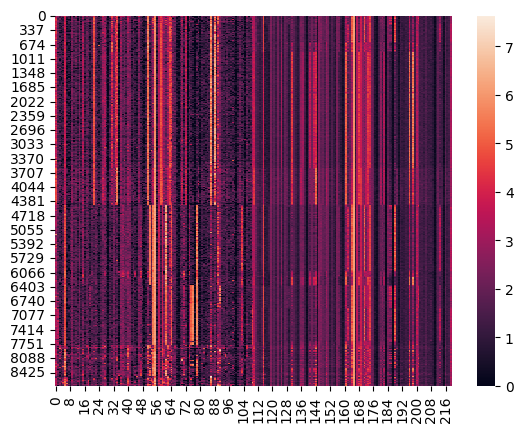

In [19]:
adata_prot
# sns.lineplot(adata_prot.X[:1000,:].mean(0))
sns.heatmap(adata_prot.X[:,:])

In [235]:
adata_2_prot

AnnData object with n_obs × n_vars = 6868 × 220
    obs: 'batch_indices', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'major_cell_types', 'X', 'Y', 'CN'
    var: 'feature_type'
    uns: 'pca', 'log1p', 'neighbors', 'spatial_clusters_colors', 'CN_colors'
    obsm: 'X_spatial', 'spatial_location', 'X_pca'
    varm: 'PCs'

# End of CN concatenation to protein features

In [20]:
# initial data analysis
sc.pp.pca(adata_rna)
sc.pp.pca(adata_prot)
sc.pp.neighbors(adata_rna, key_added='original_neighbors',use_rep='X_pca')
sc.tl.umap(adata_rna, neighbors_key='original_neighbors')
adata_rna.obsm['X_original_umap'] = adata_rna.obsm["X_umap"]
sc.pp.neighbors(adata_prot, key_added='original_neighbors',use_rep='X_pca')
sc.tl.umap(adata_prot, neighbors_key='original_neighbors')
adata_prot.obsm['X_original_umap'] = adata_prot.obsm["X_umap"]

if plot_flag:
    sc.pl.pca(adata_rna, color=['cell_types', 'major_cell_types'], title=['RNA pca minor cell types', 'RNA pca major cell types'])
    sc.pl.pca(adata_prot, color=['cell_types', 'major_cell_types'], title=['Protein pca minor cell types', 'Protein pca major cell types'])
    sc.pl.embedding(adata_rna, basis='X_umap', color=[ 'major_cell_types','cell_types'], title=['RNA UMAP major cell types','RNA UMAP major cell types'])
    sc.pl.embedding(adata_prot,basis='X_original_umap',color=['major_cell_types','cell_types'],title=['Protein UMAp major cell types','Protein UMAP major cell types'])

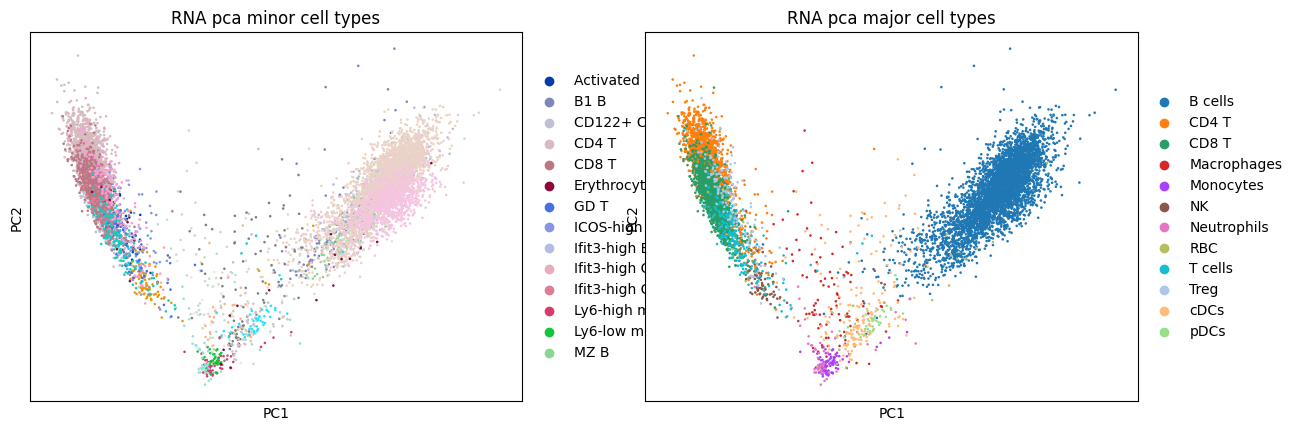

KeyError: "Could not find 'pca' or 'X_pca' in .obsm"

In [236]:
# initial data analysis
sc.pp.pca(adata_1_rna)
sc.pp.pca(adata_2_prot)
sc.pp.neighbors(adata_1_rna, key_added='original_neighbors',use_rep='X_pca')
sc.tl.umap(adata_1_rna, neighbors_key='original_neighbors')
adata_1_rna.obsm['X_original_umap'] = adata_1_rna.obsm["X_umap"]
sc.pp.neighbors(adata_2_prot, key_added='original_neighbors',use_rep='X_pca')
sc.tl.umap(adata_2_prot, neighbors_key='original_neighbors')
adata_2_prot.obsm['X_original_umap'] = adata_2_prot.obsm["X_umap"]

if plot_flag:
    sc.pl.pca(adata_rna, color=['cell_types', 'major_cell_types'], title=['RNA pca minor cell types', 'RNA pca major cell types'])
    sc.pl.pca(adata_prot, color=['cell_types', 'major_cell_types'], title=['Protein pca minor cell types', 'Protein pca major cell types'])
    sc.pl.embedding(adata_rna, basis='X_umap', color=[ 'major_cell_types','cell_types'], title=['RNA UMAP major cell types','RNA UMAP major cell types'])
    sc.pl.embedding(adata_prot,basis='X_original_umap',color=['major_cell_types','cell_types'],title=['Protein UMAp major cell types','Protein UMAP major cell types'])

### analysis to get to scatter plot

In [21]:
adata_prot_first_110_vars = adata_prot[:, adata_prot.var_names[:110]].copy()
adata_prot_second_110_vars = adata_prot[:, adata_prot.var_names[110:]].copy()
sc.pp.pca(adata_prot_first_110_vars)
sc.pp.pca(adata_prot_second_110_vars)
# plot umap each separately
sc.pp.neighbors(adata_prot_first_110_vars)
sc.tl.umap(adata_prot_first_110_vars)
sc.pp.neighbors(adata_prot_first_110_vars)
sc.tl.umap(adata_prot_first_110_vars)
sc.pp.neighbors(adata_prot_second_110_vars)
sc.tl.umap(adata_prot_second_110_vars)

if plot_flag:
    sc.pl.embedding(adata_prot_first_110_vars, basis='X_umap', color=[ 'major_cell_types','cell_types'], title=['Protein UMAP first 110 vars major cell types','Protein UMAP first 110 vars major cell types'])
    sc.pl.embedding(adata_prot_second_110_vars, basis='X_umap', color=[ 'major_cell_types','cell_types'], title=['Protein UMAP second 110 vars major cell types','Protein UMAP second 110 vars major cell types'])

In [22]:
max_possible_pca_dim_rna = min(adata_rna.X.shape[1], adata_rna.X.shape[0])
max_possible_pca_dim_prot = min(adata_prot.X.shape[1], adata_prot.X.shape[0])
sc.pp.pca(adata_rna, n_comps=max_possible_pca_dim_rna - 1)
sc.pp.pca(adata_prot, n_comps=max_possible_pca_dim_prot - 1)
# make PCA explain X% of variance
max_dim = 50
variance_ration_selected = 0.8

cumulative_variance_ratio = np.cumsum(adata_rna.uns['pca']['variance_ratio'])
n_comps_thresh = np.argmax(cumulative_variance_ratio >= variance_ration_selected) + 1
n_comps_thresh =min(n_comps_thresh,50)
if n_comps_thresh==1:
    raise ValueError('n_comps_thresh is 1, this is not good, try to lower the variance_ration_selected')
real_ratio = np.cumsum(adata_rna.uns['pca']['variance_ratio'])[n_comps_thresh]
sc.pp.pca(adata_rna, n_comps=n_comps_thresh)
print(f"Number of components explaining {real_ratio} of variance: {n_comps_thresh}")
sc.pp.pca(adata_prot)
cumulative_variance_ratio = np.cumsum(adata_prot.uns['pca']['variance_ratio'])
n_comps_thresh = np.argmax(cumulative_variance_ratio >= variance_ration_selected) + 1
n_comps_thresh =min(n_comps_thresh,50)
real_ratio = np.cumsum(adata_prot.uns['pca']['variance_ratio'])[n_comps_thresh]
sc.pp.pca(adata_prot, n_comps=n_comps_thresh)
print(f"Number of components explaining {real_ratio} of variance: {n_comps_thresh}")
if n_comps_thresh==1:
    raise ValueError('n_comps_thresh is 1, this is not good, try to lower the variance_ration_selected')

Number of components explaining 0.4758419394493103 of variance: 50
Number of components explaining 0.8055384755134583 of variance: 30


In [23]:
adata_prot

AnnData object with n_obs × n_vars = 8736 × 220
    obs: 'batch_indices', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'major_cell_types', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'X', 'Y', 'CN'
    var: 'feature_type'
    uns: 'pca', 'log1p', 'neighbors', 'spatial_clusters_colors', 'original_neighbors', 'umap'
    obsm: 'X_spatial', 'spatial_location', 'X_pca', 'X_umap', 'X_original_umap'
    varm: 'PCs'
    obsp: 'original_neighbors_distances', 'original_neighbors_connectivities'

In [24]:
archetype_list_protein = []

archetype_list_rna = []
min_k = 12  # this is where we set number of archetypes
max_k = 13
step_size = 1

evs = []
X_protein = adata_prot.obsm['X_pca'].T
total = (max_k - min_k) / step_size
for i, k in tqdm(enumerate(range(min_k, max_k, step_size)), total=total, desc='Protein Archetypes Detection'):
    archetype, _, _, _, ev = PCHA(X_protein, noc=k)
    evs.append(ev)
    archetype_list_protein.append(np.array(archetype).T)
    if i > 0 and ev - evs[i - 1] < converge:
        print('early stopping')
        break
evs = []
X_rna = adata_rna.obsm['X_pca'].T

for j, k in tqdm(enumerate(range(min_k, max_k, step_size)), total=total, desc='RNA Archetypes Detection'):
    if j > i:
        break
    archetype, _, _, _, ev = PCHA(X_rna, noc=k)
    evs.append(ev)
    archetype_list_rna.append(np.array(archetype).T)
    if j > 0 and ev - evs[j - 1] < converge:
        print('early stopping')
        break
min_len = min([len(archetype_list_protein), len(archetype_list_rna)])
archetype_list_protein = archetype_list_protein[:min_len]
archetype_list_rna = archetype_list_rna[:min_len]

Protein Archetypes Detection:   0%|          | 0/1.0 [00:00<?, ?it/s]

Protein Archetypes Detection: 100%|██████████| 1/1.0 [00:09<00:00,  9.15s/it]
RNA Archetypes Detection: 100%|██████████| 1/1.0 [00:42<00:00, 42.50s/it]


In [25]:
# loop over prot and rna archetypes and get weights for each loop over the archetypes to set a major cell type vector for each archetype
# each archetype has a proportions vector <go step by step going through this>
minor_cell_types_list = sorted(list(set(adata_prot.obs['cell_types'])))
major_cell_types_list = sorted(list(set(adata_prot.obs['major_cell_types'])))
major_cell_types_amount_prot = [adata_prot.obs['major_cell_types'].value_counts()[cell_type] for cell_type in
                                major_cell_types_list]
major_cell_types_amount_rna = [adata_rna.obs['major_cell_types'].value_counts()[cell_type] for cell_type in
                               major_cell_types_list]
assert set(adata_rna.obs['major_cell_types']) == set(adata_prot.obs['major_cell_types'])
archetype_proportion_list_rna, archetype_proportion_list_protein = [], []

for archetypes_prot, archetypes_rna in tqdm(zip(archetype_list_protein, archetype_list_rna),
                                            total=len(archetype_list_protein),
                                            desc='Archetypes generating archetypes major cell types proportiaon vector '):
    weights_prot = get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], archetypes_prot)
    weights_rna = get_cell_representations_as_archetypes_cvxpy(adata_rna.obsm['X_pca'], archetypes_rna)
    archetypes_dim = archetypes_prot.shape[1]
    archetype_num = archetypes_prot.shape[0]
    prot_arch_prop = pd.DataFrame(np.zeros((archetype_num, len(major_cell_types_list))), columns=major_cell_types_list)
    rna_arch_prop = pd.DataFrame(np.zeros((archetype_num, len(major_cell_types_list))), columns=major_cell_types_list)
    archetype_cell_proportions = np.zeros((archetype_num, len(major_cell_types_list)))
    for curr_archetype in range(archetype_num):
        df_rna = pd.DataFrame([weights_prot[:, curr_archetype], adata_rna.obs['major_cell_types'].values],
                              index=['weight', 'major_cell_types']).T
        df_prot = pd.DataFrame([weights_rna[:, curr_archetype], adata_prot.obs['major_cell_types'].values],
                               index=['weight', 'major_cell_types']).T
        df_rna = df_rna.groupby('major_cell_types')['weight'].sum()[major_cell_types_list]
        df_prot = df_prot.groupby('major_cell_types')['weight'].sum()[major_cell_types_list]
        # normalize by the amount of major cell types
        rna_arch_prop.loc[curr_archetype, :] = df_rna.values / major_cell_types_amount_rna
        prot_arch_prop.loc[curr_archetype, :] = df_prot.values / major_cell_types_amount_prot

    prot_arch_prop = (prot_arch_prop.T / prot_arch_prop.sum(1)).T
    prot_arch_prop = prot_arch_prop / prot_arch_prop.sum(0)
    rna_arch_prop = (rna_arch_prop.T / rna_arch_prop.sum(1)).T
    rna_arch_prop = rna_arch_prop / rna_arch_prop.sum(0)
    archetype_proportion_list_rna.append(rna_arch_prop.copy())
    archetype_proportion_list_protein.append(prot_arch_prop.copy())

Archetypes generating archetypes major cell types proportiaon vector : 100%|██████████| 1/1 [02:22<00:00, 142.10s/it]


In [26]:
# plotting the results of the lowest num of archetypes
if plot_flag:
    fig = plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    # sns.heatmap(reorder_rows_to_maximize_diagonal(archetype_proportion_list_rna[0])[0])
    sns.heatmap((archetype_proportion_list_rna[0]), cbar=False)
    plt.xticks()
    plt.title('RNA Archetypes')
    plt.yticks([])
    plt.ylabel('Archetypes')
    plt.subplot(1, 2, 2)
    plt.title('Protein Archetypes')
    # sns.heatmap(reorder_rows_to_maximize_diagonal(archetype_proportion_list_protein[0])[0])
    sns.heatmap((archetype_proportion_list_protein[0]), cbar=False)
    plt.suptitle('showcase the relationship between archetypes and cell types')
    plt.yticks([])
    plt.suptitle('Non-Aligned Archetypes Profiles')
    plt.ylabel('Archetypes')
    plt.show()

    new_order_1 = reorder_rows_to_maximize_diagonal(archetype_proportion_list_rna[0])[1]
    new_order_2 = reorder_rows_to_maximize_diagonal(archetype_proportion_list_protein[0])[1]
    data1 = archetype_proportion_list_rna[0].iloc[new_order_1, :]
    data2 = archetype_proportion_list_protein[0].iloc[new_order_2, :]
    # this just uses simple diagonal optimization for each one separatly, this is not final matching
    plot_archetypes_matching(data1, data2)


In [27]:
# todo find_best_pair_by_row_matching() find a mathing which has too many archetypes, should check it later
best_num_or_archetypes_index, best_total_cost, best_rna_archetype_order, best_protein_archetype_order = find_best_pair_by_row_matching(
    copy.deepcopy(archetype_proportion_list_rna), copy.deepcopy(archetype_proportion_list_protein), metric='correlation'
)

print("\nBest pair found:")
print(f"Best index: {best_num_or_archetypes_index}")
print(f"Best total matching cost: {best_total_cost}")
print(f"Row indices (RNA): {best_rna_archetype_order}")
print(f"Matched row indices (Protein): {best_protein_archetype_order}")


Pair 0: Total matching cost = 0.28076782533580485

Best pair found:
Best index: 0
Best total matching cost: 0.28076782533580485
Row indices (RNA): [ 0  1  2  3  4  5  6  7  8  9 10 11]
Matched row indices (Protein): [ 0  3  7  5 10  6  1 11  2  8  4  9]


In [28]:
# reorder the archetypes based on the best matching so the archtypes across modalities are aligned
best_archetype_rna_prop = archetype_proportion_list_rna[best_num_or_archetypes_index].iloc[
                          best_rna_archetype_order, :].reset_index(drop=True)
# best_archetype_rna_prop = pd.DataFrame(best_archetype_rna_prop)
best_archetype_prot_prop = archetype_proportion_list_protein[best_num_or_archetypes_index].iloc[
                           best_protein_archetype_order, :].reset_index(drop=True)
# best_archetype_prot_prop = pd.DataFrame(best_archetype_prot_prop)
if plot_flag:
    plot_archetypes_matching(best_archetype_rna_prop, best_archetype_prot_prop,5)

In [29]:
best_archetype_prot_prop.idxmax(axis=0)

B cells         9
CD4 T           2
CD8 T           4
Macrophages     8
Monocytes       1
NK             10
Neutrophils     1
RBC             5
T cells        10
Treg           11
cDCs            3
pDCs            6
dtype: int64

In [30]:
if plot_flag:
    # add lable and laegend
    best_archetype_prot_prop.idxmax(axis=0).plot(kind='bar', color='red', hatch='\\',label='Protein')
    best_archetype_rna_prop.idxmax(axis=0).plot(kind='bar', alpha=0.5, hatch='/',label='RNA')
    plt.title('show overlap of cell types proportions in archetypes')
    # add legend
    plt.legend()
    plt.xlabel('Major Cell Types')
    plt.ylabel('Proportion')
    plt.show()
    compare_matchings(archetype_proportion_list_rna, archetype_proportion_list_protein, metric='cosine',
                      num_trials=100)



In [31]:
best_protein_archetype_order

array([ 0,  3,  7,  5, 10,  6,  1, 11,  2,  8,  4,  9])

In [32]:
# get all cells archetype vec and see how they match
ordered_best_rna_archetype = archetype_list_rna[best_num_or_archetypes_index][best_protein_archetype_order, :]
ordered_best_protein_archetype = archetype_list_protein[best_num_or_archetypes_index][best_rna_archetype_order, :]
cells_archetype_vec_rna = get_cell_representations_as_archetypes_cvxpy(adata_rna.obsm['X_pca'],
                                                                       ordered_best_rna_archetype)
cells_archetype_vec_prot = get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'],ordered_best_protein_archetype)

adata_rna.obsm['archetype_vec'] = pd.DataFrame(cells_archetype_vec_rna, index=adata_rna.obs.index,columns=range(cells_archetype_vec_rna.shape[1]))
adata_prot.obsm['archetype_vec'] = pd.DataFrame(cells_archetype_vec_prot, index=adata_prot.obs.index,columns=range(cells_archetype_vec_prot.shape[1]))
adata_rna.obsm['archetype_vec'].columns = adata_rna.obsm['archetype_vec'].columns.astype(str)
adata_prot.obsm['archetype_vec'].columns = adata_prot.obsm['archetype_vec'].columns.astype(str)

adata_rna.obs['archetype_label'] = pd.Categorical(np.argmax(cells_archetype_vec_rna, axis=1))
adata_prot.obs['archetype_label'] = pd.Categorical(np.argmax(cells_archetype_vec_prot, axis=1))
adata_rna.uns['archetypes'] = ordered_best_rna_archetype
adata_prot.uns['archetypes'] = ordered_best_protein_archetype
metrics = ['euclidean', 'cityblock', 'cosine', 'correlation', 'chebyshev']
evaluate_distance_metrics(cells_archetype_vec_rna, cells_archetype_vec_prot, metrics)

Evaluating distance metric: euclidean
Mean Rank: 2236.15 (Random: 4368.50)
MRR: 0.0045 (Random: 0.0011)
Improvement over random (Rank): 48.82%
Improvement over random (MRR): 0.34%

Evaluating distance metric: cityblock
Mean Rank: 2007.40 (Random: 4368.50)
MRR: 0.0046 (Random: 0.0011)
Improvement over random (Rank): 54.06%
Improvement over random (MRR): 0.35%

Evaluating distance metric: cosine
Mean Rank: 1988.31 (Random: 4368.50)
MRR: 0.0045 (Random: 0.0011)
Improvement over random (Rank): 54.50%
Improvement over random (MRR): 0.34%

Evaluating distance metric: correlation
Mean Rank: 1996.36 (Random: 4368.50)
MRR: 0.0046 (Random: 0.0011)
Improvement over random (Rank): 54.31%
Improvement over random (MRR): 0.35%

Evaluating distance metric: chebyshev
Mean Rank: 2371.64 (Random: 4368.50)
MRR: 0.0046 (Random: 0.0011)
Improvement over random (Rank): 45.72%
Improvement over random (MRR): 0.35%



{'euclidean': {'mean_rank': 2236.152815934066,
  'expected_mean_rank': 4368.5,
  'mrr': 0.004466954363375333,
  'expected_mrr': 0.0011049084931577986,
  'rank_improvement': 0.48823060883020813,
  'mrr_improvement': 0.0033657647322561752,
  'ranks': array([ 360, 2028,  769, ...,  484,  427,  417])},
 'cityblock': {'mean_rank': 2007.4014423076924,
  'expected_mean_rank': 4368.5,
  'mrr': 0.004639704722640549,
  'expected_mrr': 0.0011049084931577986,
  'rank_improvement': 0.540606424199727,
  'mrr_improvement': 0.0035387061759913933,
  'ranks': array([ 403, 4201,  593, ...,  493,  431,  456])},
 'cosine': {'mean_rank': 1988.3129578754579,
  'expected_mean_rank': 4368.5,
  'mrr': 0.004510190246999414,
  'expected_mrr': 0.0011049084931577986,
  'rank_improvement': 0.544976998769214,
  'mrr_improvement': 0.0034090484404170184,
  'ranks': array([ 414, 3806,  595, ...,  575,  340,  573])},
 'correlation': {'mean_rank': 1996.362065018315,
  'expected_mean_rank': 4368.5,
  'mrr': 0.0046333539350

In [33]:
# add the best matching archetype to the metadata
adata_rna.obs['archetype_label'] = pd.Categorical(np.argmax(cells_archetype_vec_rna, axis=1))
adata_prot.obs['archetype_label'] = pd.Categorical(np.argmax(cells_archetype_vec_prot, axis=1))

In [34]:
if plot_flag:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.ylabel('Archetypes')
    plt.xlabel('PCA dimensiton of archetypes')
    plt.title('RNA Archetypes')
    sns.heatmap(ordered_best_rna_archetype)
    plt.subplot(1, 2, 2)
    plt.ylabel('Archetypes')
    plt.xlabel('PCA dimensiton of archetypes')
    plt.title('Protein Archetypes')
    sns.heatmap(ordered_best_protein_archetype)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('RNA Archetypes')
    plt.ylabel('Archetypes')
    _, row_order = reorder_rows_to_maximize_diagonal(best_archetype_rna_prop)
    sns.heatmap(pd.DataFrame(best_archetype_rna_prop).iloc[row_order], cbar=False)  
    plt.yticks([])
    plt.ylabel('Archetypes')
    plt.subplot(1, 2, 2)
    
    plt.ylabel('Archetypes')
    plt.title('Protein Archetypes')
    sns.heatmap(pd.DataFrame(best_archetype_prot_prop).iloc[row_order], cbar=False)  
    plt.ylabel('Archetypes')
    # plt.suptitle('The more similar the better, means that the archetypes are aligned in explaining different cell types')
    plt.suptitle('Aligned Archetypes Profiles')
    plt.yticks([])

    plt.show()
    



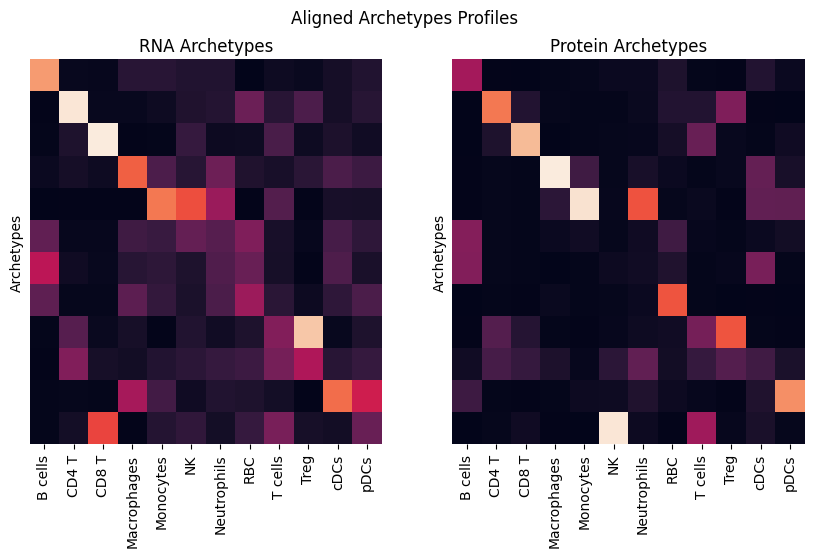

In [35]:

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('RNA Archetypes')
    plt.ylabel('Archetypes')
    _, row_order = reorder_rows_to_maximize_diagonal(best_archetype_rna_prop)
    sns.heatmap(pd.DataFrame(best_archetype_rna_prop).iloc[row_order], cbar=False)  
    plt.yticks([])
    plt.ylabel('Archetypes')
    plt.subplot(1, 2, 2)
    
    plt.ylabel('Archetypes')
    plt.title('Protein Archetypes')
    sns.heatmap(pd.DataFrame(best_archetype_prot_prop).iloc[row_order], cbar=False)  
    plt.ylabel('Archetypes')
    # plt.suptitle('The more similar the better, means that the archetypes are aligned in explaining different cell types')
    plt.suptitle('Aligned Archetypes Profiles')
    plt.yticks([])

    plt.show()
    

In [36]:

archetype_distances = cdist(cells_archetype_vec_rna,
                            cells_archetype_vec_prot, metric='correlation')
if plot_flag:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(np.log1p(archetype_distances[:1000, :1000]))
    plt.title(
        'if diagonal bias this mean that the \nmathing is somewhat correct (remember that cells are sorted by tyeps for better visualization ')
    plt.subplot(1, 2, 2)
    # plt.plot(archetype_distances.argmin(axis=0))
    plt.title('If this looks like line, matching \nARE THE SAME AND NOT ACROSS MODALITIES')
    min_values_highlight = archetype_distances.copy()
    min_values_highlight[archetype_distances.argmin(axis=0), range(len(archetype_distances.argmin(axis=0)))] = 100
    sns.heatmap(min_values_highlight[:5000, :5000])
    # sns.heatmap(np.log1p(archetype_distances[:100,:100]))
    plt.show()


In [37]:
if plot_flag:
    ax = sns.histplot(adata_rna.obs, x='archetype_label', hue='major_cell_types', multiple='fill', stat='proportion')
    plt.xticks(rotation=45)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title('Proportion of Archetypes in Major Cell Types  in RNA')
    plt.show()

    ax = sns.histplot(adata_prot.obs, x='archetype_label', hue='major_cell_types', multiple='fill', stat='proportion')
    plt.xticks(rotation=45)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title('Proportion of Archetypes in Major Cell Types in Protein')


In [38]:
def plot_scatter(mtx1, mtx2, n_samples):
    pca = PCA(n_components=2)
    embeddings_combined = np.vstack((mtx1, mtx2))
    tsne_results = pca.fit_transform(embeddings_combined)
    # tsne_results = pca.fit_transform(embeddings_combined)

    labels = ['Dataset 1'] * n_samples + ['Dataset 2'] * n_samples
    df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    df['Dataset'] = labels

    sns.scatterplot(x='TSNE1', y='TSNE2', hue='Dataset', data=df)
    plt.title('t-SNE of Aligned Embeddings')
    plt.show()


In [39]:
# # weights = get_cell_representations_as_archetypes(adata_prot.obsm['X_pca'], archetypes[-1].T)
# distances_array = []
# for arche in archetype:
#     distances = np.linalg.norm(adata_prot.obsm['X_pca']- arche, axis=1)
#     distances_array.append(distances)
# # np.linalg.norm(adata.obsm['X_pca'],archetype.T)
#     
# 
# # Columns: Cell 1 Cell 2 Cell 3 Cell 4
# # Row: anchor 
# # column, row distance from cell to anchor
# # we want minimum
# distances_array = np.array(distances_array)
# distances_array = distances_array.T
# row_argmin = np.argmin(distances_array, axis=1)
# adata.obs['archetype'] = row_argmin

### weights

In [40]:
# send this for gene and protein as well as matching arrays over slack
# weights = get_cell_representations_as_archetypes_cvxpy(adata.obsm['X_pca'], archetype.T)
# weights_df = pd.DataFrame(weights)
# weights_df.to_csv("rna_weights.csv")
# row_argmax = np.argmax(weights, axis=1)
# adata.obs['corr_archetype'] = row_argmax
# len(set((adata.obs['major_cell_types'])))

In [41]:
best_archetype_rna_prop

,B cells,CD4 T,CD8 T,Macrophages,Monocytes,NK,Neutrophils,RBC,T cells,Treg,cDCs,pDCs
0,0.137801,0.008608,0.009296,0.089494,0.080995,0.140525,0.122076,0.175575,0.034947,0.010002,0.100364,0.066459
1,0.001642,0.003814,0.003501,0.002731,0.388571,0.343755,0.209658,0.004133,0.118432,0.002698,0.035856,0.033583
2,0.002364,0.535865,0.011479,0.011612,0.021223,0.045352,0.051136,0.150007,0.058910,0.109132,0.031206,0.056430
3,0.251285,0.023095,0.010656,0.055579,0.064718,0.043906,0.114166,0.144529,0.033884,0.002355,0.111089,0.037816
4,0.005330,0.043535,0.543421,0.002240,0.004408,0.077685,0.018314,0.020101,0.104512,0.020263,0.041624,0.023357
5,0.133173,0.006767,0.008042,0.130860,0.073734,0.039061,0.106274,0.212231,0.059621,0.018252,0.066484,0.107250
6,0.005345,0.007715,0.004347,0.224968,0.094664,0.022208,0.048354,0.043418,0.028107,0.003517,0.376793,0.277432
7,0.003794,0.177832,0.033088,0.026890,0.049411,0.063681,0.078462,0.085690,0.161433,0.234599,0.058549,0.076813
8,0.016752,0.030021,0.019922,0.361614,0.109322,0.056819,0.151231,0.045026,0.034067,0.060070,0.107537,0.085100
9,0.431956,0.012288,0.009528,0.058744,0.059029,0.048491,0.048076,0.000003,0.019565,0.014709,0.031227,0.048639


In [42]:
if plot_flag:
    # plot both heatmaps as subplots, and add titel the more similar the better:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('RNA Archetypes')
    plt.ylabel('Archetypes')
    _,row_order = reorder_rows_to_maximize_diagonal(best_archetype_rna_prop)
    sns.heatmap(pd.DataFrame(best_archetype_rna_prop).loc[row_order,:])
    # sns.heatmap(pd.DataFrame(best_archetype_rna_prop))
    plt.subplot(1, 2, 2)
    plt.ylabel('Archetypes')
    # sns.heatmap(best_archetype_prot_prop)
    sns.heatmap(pd.DataFrame(best_archetype_prot_prop).loc[row_order,:])
    # sns.heatmap(pd.DataFrame(best_archetype_prot_prop).iloc[row_order,:])
    plt.title('Protein Archetypes')
    plt.suptitle('The more similar the better, means that the archtypes are aligned in explaining different cell types')
    plt.show()
    # errors = np.abs(ordered_arch_prot - ordered_arch_rna)
    # random_error =np.abs(ordered_arch_prot - np.random.permutation(ordered_arch_rna))
    # plt.plot(errors.values.flatten())
    # plt.plot(random_error.values.flatten())
    # plt.legend(['Error', 'Random Error'])
    # plt.show()

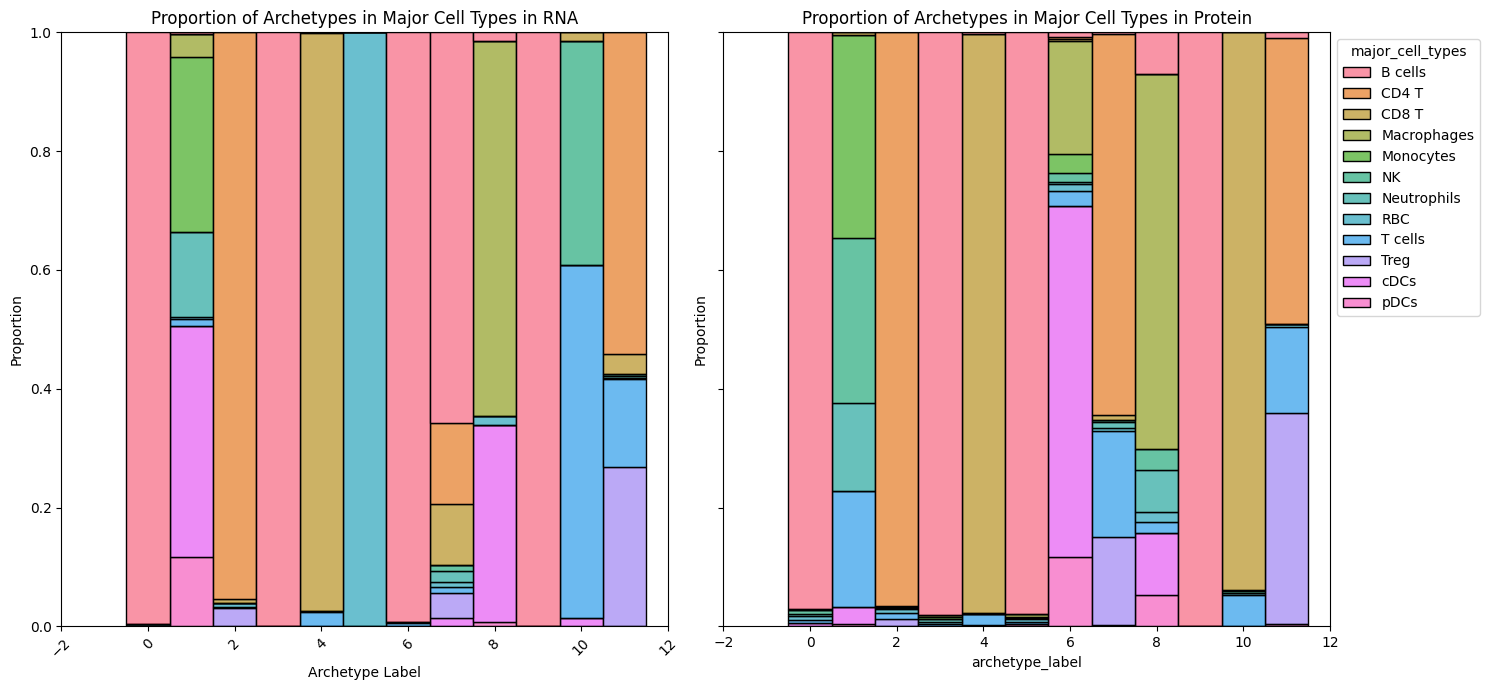

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot for RNA
ax = sns.histplot(adata_rna.obs, x='archetype_label', hue='major_cell_types', multiple='fill', stat='proportion', ax=axes[0])
axes[0].set_xticks(axes[0].get_xticks())  # Set the ticks first
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Proportion of Archetypes in Major Cell Types in RNA')
axes[0].set_xlabel('Archetype Label')
axes[0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axes[0].get_legend().remove()  # Remove the legend from the left subplot

# Plot for Protein
ax = sns.histplot(adata_prot.obs, x='archetype_label', hue='major_cell_types', multiple='fill', stat='proportion', ax=axes[1])
axes[1].set_xticks(axes[1].get_xticks())  # Set the ticks first
axes[1].set_yticklabels([])
axes[1].set_title('Proportion of Archetypes in Major Cell Types in Protein')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()
# TODO this plot does not add up for some reason, it seems that the archetypes are not aligned correctly

In [44]:
if plot_flag:
    data_points_rna = adata_rna.obsm['X_pca']
    data_points_prot = adata_prot.obsm['X_pca']
    data_point_archetype_indices_rna = list(np.argmax(cells_archetype_vec_rna, axis=1))
    data_point_archetype_indices_prot = list(np.argmax(cells_archetype_vec_prot, axis=1))

    # use ground truth cell types
    show_ground_truth =True
    if show_ground_truth:
        major_or_minor = 'cell_types'
        major_or_minor = 'major_cell_types'
        samples_cell_types_rna = list(adata_rna.obs[major_or_minor])
        samples_cell_types_prot = list(adata_prot.obs[major_or_minor])
    else: #
        # Get the archetype indices for each data point
        current_cell_types_list = major_cell_types_list
        # Map the archetype indices to cell type names
        samples_cell_types_rna = [current_cell_types_list[i] for i in data_point_archetype_indices_rna]
        samples_cell_types_prot = [current_cell_types_list[i] for i in data_point_archetype_indices_prot]

    

    # Optionally limit the number of samples
    num_samples = 50000  # or any number you prefer
    data_points_rna_plot = data_points_rna[:num_samples]
    data_points_prot_plot = data_points_prot[:num_samples]
    samples_cell_types_rna_plot = samples_cell_types_rna[:num_samples]
    samples_cell_types_prot_plot = samples_cell_types_prot[:num_samples]
    data_point_archetype_indices_rna_plot = data_point_archetype_indices_rna[:num_samples]
    data_point_archetype_indices_prot_plot = data_point_archetype_indices_prot[:num_samples]

    # Create a consistent color mapping
    all_cell_types = set(samples_cell_types_rna_plot + samples_cell_types_prot_plot)
    all_cell_types.discard('archetype')
    all_cell_types = [ct for ct in all_cell_types if ct is not np.nan]
    all_cell_types = sorted(all_cell_types)
    palette = sns.color_palette("tab20", len(all_cell_types))
    cell_type_colors = {cell_type: color for cell_type, color in zip(all_cell_types, palette)}
    cell_type_colors["archetype"] = "black"

    # Call the updated function with the color mapping
    plot_archetypes(
        data_points_rna_plot,
        ordered_best_rna_archetype,
        samples_cell_types_rna_plot,
        data_point_archetype_indices_rna_plot,
        modality='RNA',
        cell_type_colors=cell_type_colors
    )
    plot_archetypes(
        data_points_prot_plot,
        ordered_best_protein_archetype,
        samples_cell_types_prot_plot,
        data_point_archetype_indices_prot_plot,
        modality='Protein',
        cell_type_colors=cell_type_colors
    )


In [45]:
adata_archetype_rna = AnnData(adata_rna.obsm['archetype_vec'])
adata_archetype_prot = AnnData(adata_prot.obsm['archetype_vec'])
adata_archetype_rna.obs = adata_rna.obs
adata_archetype_prot.obs = adata_prot.obs
adata_archetype_rna.index = adata_rna.obs.index
adata_archetype_prot.index = adata_prot.obs.index
if plot_flag:
    sc.pp.pca(adata_archetype_rna)
    sc.pp.pca(adata_archetype_prot)
    sc.pl.pca(adata_archetype_rna, color=['major_cell_types', 'archetype_label', 'cell_types'])
    sc.pl.pca(adata_archetype_prot, color=['major_cell_types', 'archetype_label', 'cell_types'])
    sc.pp.neighbors(adata_archetype_rna)
    sc.pp.neighbors(adata_archetype_prot)
    sc.tl.umap(adata_archetype_rna)
    sc.tl.umap(adata_archetype_prot)
    sc.pl.umap(adata_archetype_rna, color=['major_cell_types', 'archetype_label', 'cell_types'])
    sc.pl.umap(adata_archetype_prot, color=['major_cell_types', 'archetype_label', 'cell_types'])

In [46]:
if plot_flag:
    sc.pp.neighbors(adata_rna)
    sc.pp.neighbors(adata_prot)
    sc.tl.umap(adata_rna)
    sc.tl.umap(adata_prot)
    sc.pl.umap(adata_rna, color='archetype_label', title='RNA Archetypes')
    sc.pl.umap(adata_prot, color='archetype_label', title='Protein Archetypes')

In [47]:
adata_rna.obsm['archetype_vec']

,0,1,2,3,4,5,6,7,8,9,10,11
index,,,,,,,,,,,,
ACAGGGAAGACATACA-1,0.075889,0.021590,0.000170,0.053668,0.000122,0.000280,0.691049,0.121417,0.011308,0.000234,0.024895,-0.000621
TCCTCTTTCTCGACGG-1,0.187352,0.021313,0.017128,0.000143,-0.000057,0.000053,0.415800,0.011087,0.045952,0.248927,0.052717,-0.000415
TACAACGGTCCCGCAA-1,0.215904,0.119366,0.000102,-0.000063,0.000098,0.004922,0.596848,0.017865,-0.000042,-0.000110,0.022177,0.022932
TTCAGGATCTATACGG-1,0.083758,0.035153,0.000090,0.238574,0.000125,0.003978,0.619708,0.018983,-0.000031,-0.000018,-0.000095,-0.000225
ACTATCTCAGCTGTAT-1,0.001079,0.138940,-0.000093,0.000099,0.000056,0.000694,0.690510,0.168861,0.000115,-0.000015,0.000567,-0.000813
...,...,...,...,...,...,...,...,...,...,...,...,...
GATCACAGTAAGGTCG-1,0.000689,0.525606,-0.000136,0.000081,0.020495,0.001139,0.350332,0.018998,0.066438,-0.001247,0.017052,0.000553
TTCCTCTCACGCTGAC-1,0.000433,0.586127,-0.000578,0.000639,-0.001051,0.000067,0.316966,0.099790,-0.000140,0.000407,-0.001472,-0.001186
TACCGAACACAGCGCT-1,0.016438,0.598404,-0.000182,-0.000062,0.008049,0.000548,0.270373,0.051618,0.021558,0.000938,0.032670,-0.000352


In [48]:
# save all adata objects with time stamp
clean_uns_for_h5ad(adata_prot)
clean_uns_for_h5ad(adata_rna)
time_stamp = pd.Timestamp.now().strftime("%Y-%m-%d-%H-%M-%S")
adata_rna.write(f'data/adata_rna_{time_stamp}.h5ad')
adata_prot.write(f'data/adata_prot_{time_stamp}.h5ad')
adata_archetype_rna.write(f'data/adata_archetype_rna_{time_stamp}.h5ad')
adata_archetype_prot.write(f'data/adata_archetype_prot_{time_stamp}.h5ad')
# load the latest of each sort by time as if I dont have the time stamp, read all files in the right name prefix and sort by time in a folder
folder = 'data/'
file_prefixes = ['adata_rna_', 'adata_prot_', 'adata_archetype_rna_', 'adata_archetype_prot_']

# Load the latest files (example)
latest_files = {prefix: get_latest_file(folder, prefix) for prefix in file_prefixes}
adata_rna = sc.read(latest_files['adata_rna_'])
adata_prot = sc.read(latest_files['adata_prot_'])
adata_archetype_rna = sc.read(latest_files['adata_archetype_rna_'])
adata_archetype_prot = sc.read(latest_files['adata_archetype_prot_'])



In [49]:
adata_prot

AnnData object with n_obs × n_vars = 8736 × 220
    obs: 'batch_indices', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'major_cell_types', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'X', 'Y', 'CN', 'archetype_label'
    var: 'feature_type'
    uns: 'archetypes', 'log1p', 'neighbors', 'original_neighbors', 'pca', 'spatial_clusters_colors', 'umap'
    obsm: 'X_original_umap', 'X_pca', 'X_spatial', 'X_umap', 'archetype_vec', 'spatial_location'
    varm: 'PCs'
    obsp: 'original_neighbors_connectivities', 'original_neighbors_distances'

In [50]:
pd.Categorical# embedding_dimensions = []  # Example dimensions from n to m
# mean_pairwise_distances = []
# ot_costs = []
# metric = 'cosine'  # 'euclidean' or 'cosine'
# # Number of samples in your datasets
#
# # Loop over each embedding dimension
# for archetypes_prot, archetypes_ran in (zip(archetype_proportion_list_rna,archetype_proportion_list_protein)):
#     try:
#         ds1_embeddings = get_cell_representations_as_archetypes(adata_prot.obsm['X_pca'], archetypes_prot)
#         ds2_embeddings = get_cell_representations_as_archetypes(adata_rna.obsm['X_pca'], archetypes_ran)
#     except:
#         print(f'could not find match for archetypes of length {len(archetypes_prot)} ')
#         continue
#
#     embedding_dimensions.append(len(archetypes_prot))
#     n_samples = ds1_embeddings.shape[0]
#     # Standardize embeddings
#     scaler1 = StandardScaler()
#     scaler2 = StandardScaler()
#     ds1_embeddings = scaler1.fit_transform(ds1_embeddings)
#     ds2_embeddings = scaler2.fit_transform(ds2_embeddings)
#
#     # Step 2: Align Dimensions using Procrustes Analysis
#     mtx1, mtx2, disparity = procrustes(ds1_embeddings, ds2_embeddings)
#     # mtx1 and mtx2 are the aligned embeddings
#
#     # Alternative: Align Dimensions using CCA
#     # cca = CCA(n_components=dim)
#     # ds1_embeddings_cca, ds2_embeddings_cca = cca.fit_transform(ds1_embeddings, ds2_embeddings)
#     # Use ds1_embeddings_cca and ds2_embeddings_cca for further calculations
#
#     # Step 3: Compute Pairwise Distances between corresponding samples
#     pairwise_distances = np.linalg.norm(mtx1 - mtx2, axis=1, metric='cosine')
#
#     if metric == 'euclidean':
#         pairwise_distances = np.linalg.norm(mtx1 - mtx2, axis=1)
#     elif metric == 'cosine':
#         # Normalize rows to compute cosine similarity
#         rna_norm = mtx1 / np.linalg.norm(mtx1, axis=1, keepdims=True)
#         protein_random_norm = mtx2 / np.linalg.norm(mtx2, axis=1, keepdims=True)
#         cosine_similarity = np.sum(rna_norm * protein_random_norm, axis=1)
#         pairwise_distances = 1 - cosine_similarity  # Cosine distance
#     else:
#         raise ValueError("Unsupported metric. Use 'euclidean' or 'cosine'.")
#
#     mean_distance = np.mean(pairwise_distances)
#     mean_pairwise_distances.append(mean_distance)
#     print(f"Mean Pairwise Distance: {mean_distance}")
#
#     # Step 4: Compute Optimal Transport Cost
#     # Create cost matrix between all samples (optional, since datasets are coupled)
#     cost_matrix = cdist(mtx1, mtx2, metric='cosine')
#
#     # Since datasets are coupled, create uniform distributions
#     a = np.ones(n_samples) / n_samples
#     b = np.ones(n_samples) / n_samples
#
#     # Compute OT cost using Sinkhorn algorithm
#     lambda_reg = 1e-3  # Entropic regularization parameter
#     ot_cost = ot.sinkhorn2(a, b, cost_matrix, lambda_reg)
#     ot_costs.append(ot_cost)
#     print(f"Optimal Transport Cost: {ot_cost}")
#     print("-" * 50)
#
# # Step 5: Compare Embedding Spaces
# # Plotting the results
# plt.figure(figsize=(12, 5))
#
# plt.subplot(1, 2, 1)
# plt.plot(embedding_dimensions, mean_pairwise_distances, marker='o')
# plt.title('Mean Pairwise Distances vs. Embedding Dimension')
# plt.xlabel('Embedding Dimension')
# plt.ylabel('Mean Pairwise Distance')
#
# plt.subplot(1, 2, 2)
# plt.plot(embedding_dimensions, ot_costs, marker='o', color='red')
# plt.title('Optimal Transport Costs vs. Embedding Dimension')
# plt.xlabel('Embedding Dimension')
# plt.ylabel('Optimal Transport Cost')
#
# plt.tight_layout()
# plt.show()
#
# # Identify the best embedding space
# best_dimension_index = np.argmin(mean_pairwise_distances)
# best_embedding_dimension = embedding_dimensions[best_dimension_index]
# print(f"The best embedding dimension based on mean pairwise distance is: {best_embedding_dimension}")
#
# best_ot_index = np.argmin(ot_costs)
# best_ot_dimension = embedding_dimensions[best_ot_index]
# print(f"The best embedding dimension based on OT cost is: {best_ot_dimension}")


pandas.core.arrays.categorical.Categorical